![Playing cards in the hand (Alessandro Bogliari ©)](alessandro-bogliari-43LcbfI-tok-unsplash.jpg)

A while ago I was introduced to a simple card game titled [_The game_ by Steffen Benndorf](https://www.spiel-des-jahres.de/spiele/the-game/).

Unlike many other games, _The game_ has a unique touch, because it is a collaborative card game.

The rules of the game are very simple. There are four piles, two of which start at 1 and ascend to 100. The other two piles start at 100 and descend to 1. Players take turns to place cards on the piles. If they manage to put down all cards, they win. Otherwise, _The game_ wins.

_The game_ comes with two additional rules:

1. Players can communicate by indicating to play higher (or lower) cards, but can never say any exact number
2. When a player has a card with +10 or -10 the value of the pile (e.g 5 and 15) they can increment or decrement the deck (trick)

While the rules are easily explained, beating _The game_ is not trivial. I was curious how to best approach _The game_ in order to increase my (or our) win rate.

Luckily, Monte Carlo simulations [@Kroese_Taimre_Botev_2011] can help to shed some light onto how to become better players.

## Implementing a simulation

To simulate any game, we need to hold a game state. In our case, we have 4 piles (two ascending and two descending). Further we have $n$ additional piles with the cards of our players (which we will call hands here). For our game to start we need to deal cards in turn to all the players. In Python, we could initialize the game state like so:

```python
# Initialize the game
game = ([1], [1], [100], [100])
deck = list(range(2, 100))  # cards from 2 to 99
random.shuffle(deck)

player_hands = [[] for _ in range(num_players)]
for _ in range(num_cards):
    for hand in player_hands:
        hand.append(deck.pop())
```

Once the game has been initialized, we would like to make sure the game is simulated for as long as the following conditions are met:

1. The deck still contains cards
2. Players still have cards
3. There are still turns that can be played

The two first conditions are easy to verify. If we use [pop](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists) to remove cards from the deck (and player hands), eventually they should wind up empty. This can be checked with the [length property](https://docs.python.org/3/library/functions.html#len):

```python
while len(deck) and len(list(chain.from_iterable(player_hands))):
    pass
```

Lastly, we need to check wether there are still cards that can be played. To do this, we introduce a `game_running` variable. Any time a card is picked (see [strategies](#choosing-a-strategy)), we will verify wether the picked card can be played. This can be done using [Python's operator package](https://docs.python.org/3/library/operator.html). Our preliminary code now looks like this:

```python
# Start playing the game
cards_played = 0
game_running = True

# The game is running so long as there are cards in the deck or player hands
while len(deck) and len(list(chain.from_iterable(player_hands))) and game_running:
    for hand in player_hands:
        # Choose the deck and card to play using the strategy
        deck_to_play, card_to_play = strategy(
            game,
            hand
        )

        # Draw the card
        card = hand.pop(card_to_play)

        # Check if it is valid for the selected deck
        comparator = gt if deck_to_play < 2 else lt
        if comparator(card, game[deck_to_play][-1]):
            game[deck_to_play].append(card)
            cards_played += 1

            if len(deck):
                hand.append(deck.pop())
        else:
            game_running = False
            break
```

With the basic game logic in place, it is time to discuss which options players have.

## Choosing a strategy

For this simulation we will focus on the individual choices a player can take. While collaboration certainly is an important aspect of the game, we can create some basic strategies on a player-level. These include:

- playing a random card onto a random (but valid) pile
- playing the card with the smallest distance to any of the piles
- playing a card such that we can apply the trick

In order to implement the different strategies, it is useful to define what a strategy actually will do:

```python
from typing import Callable

Game = tuple[list[int], list[int], list[int], list[int]]
Move = tuple[int, int]
Strategy = Callable[[Game, list[int]], Move]
```

A strategy will be a function, which receives a game (a tuple of 4 integer lists) and a list of integers. A strategy produces a move (a tuple of integers). The move will indicate the index of the deck to play (from 0 to 3), and the index of the card to play relative to the (players) hand.

### random strategy

To implement the random strategy, we can enumerate all the cards in our hand, and check if they can be played. From all the valid moves, we pick one:

```python
valid_cards = []
for index, g in enumerate(game):
    comparator = gt if index < 2 else lt
    for index_card, card in enumerate(hand):
        if comparator(card, g[-1]):
            valid_cards.append((index, index_card))

deck_to_play, card_to_play = random.choice(valid_cards)
```

### minimal distance strategy

To get the card with the smallest distance, we first calculate the minimum (for the ascending pile) and maximum (for the descending pile) respectively. We can use the [absolute function](https://docs.python.org/3/library/functions.html#abs) to get the smallest difference. Once we have the smallest difference, we need to find the correct pile like so:

```python
ascending_values = [game[0][-1], game[1][-1]]
min_ascending = min(ascending_values)
descending_values = [game[2][-1], game[3][-1]]
max_descending = max(descending_values)

sorted_hand = sorted(hand)
if abs(min_ascending - sorted_hand[0]) < abs(max_descending - sorted_hand[-1]):
    card_to_play = hand.index(sorted_hand[0])
    if game[0][-1] == min_ascending:
        deck_to_play = 0
    else:
        deck_to_play = 1
else:
    card_to_play = hand.index(sorted_hand[-1])
    if game[2][-1] == max_descending:
        deck_to_play = 2
    else:
        deck_to_play = 3
```

### trick strategy

The trick strategy is similar to the minimal distance strategy, but instead of finding the smallest absolute value, we want to find values that have a difference of 10:

```python
possible_cards = []

for game_index, g in enumerate(game):
    for card_deck in g:
        for card_index, card in enumerate(hand):
            if abs(card_deck - card) == 10:
                possible_cards.append((game_index, card_index))

if len(possible_cards):
    return random.choice(possible_cards)
```

## Putting it all together

To finalise the code for our simulation, all we need to do is to wrap the snippets from this blog article into functions. You can find [the complete code for the simulation attached](./simulation.py).

In order to go from a simulation to a Monte Carlo simulation, we want to:

1. Modify one experimental parameter at a time
2. Repeat our experiment e.g 1000 times
3. Record the outcome of the experiment

Luckily, the [product](https://docs.python.org/3/library/itertools.html#itertools.product) function helps us do this:

```python
from itertools import product

from simulation import simulate_game, random_strategy, minimal_distance_strategy, trick_strategy

_STRATEGY_TO_CB = {
    "random": random_strategy,
    "minimal": minimal_distance_strategy,
    "trick": trick_strategy
}

repeats = 1000

strategies = ["random", "minimal", "trick"]
players = list(range(1, 8))

for i in range(repeats):
    for n_players, strategy in product(players, strategies):
        cards_played_total = simulate_game(n_players, _STRATEGY_TO_CB[strategy])
        # we write a TSV file with the number of players, strategy and total cards played
        print("\t".join([str(item) for item in [n_players, strategy, cards_played_total]]))
```

The [Monte Carlo simulation](./monte_carlo.py) and [output of the simulation](./simulation.tsv) are attached to this blog post for reproducibility.

## Results

To evaluate our simulation we need to read the output of our simulation (dataset):

In [3]:
#| label: tbl-simulation
#| tbl-cap: The simulation table containing number of players, strategy, and the number of cards played as a result.

import pandas as pd
df = pd.read_csv("simulation.tsv", delimiter="\t", names=["num_players", "strategy", "cards_played"])
df.head()

,num_players,strategy,cards_played
0,1,random,10
1,1,minimal,6
2,1,trick,13
3,2,random,11
4,2,minimal,9


We can visualize this dataframe as a line plot indicating different types of strategy, and the _gain_ in terms of how many cards have been played. 

As one can see from @fig-line-plot-results, in the random strategy, the number of players positively affects the number of cards played. Contrary to this, for the minimal and trick strategy, more players will mean less cards played.

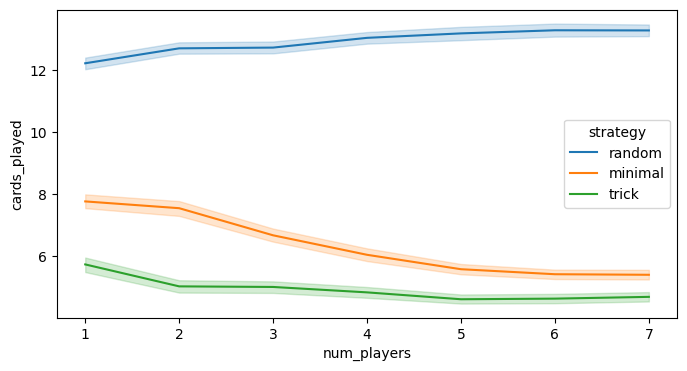

In [2]:
#| label: fig-line-plot-results
#| fig-cap: "Number of cards played for different strategies and player sizes"

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(df, x="num_players", y="cards_played", hue="strategy", ax=ax)
plt.show()

While in the random strategy more cards are played then in the minimal and trick strategy, none of the strategies can beat _The game_. We can verify this fact by retrieving the maximum number of cards played:

In [5]:
df["cards_played"].max()

31

Indeed, 31 is far from the desired 98 cards. _The game_ has won all of our $7x3x1000 = 21000$ games.

## Discussion

_The game_ claims to be a highly cooperative game, that can't be beaten by chance. Using Monte Carlo simulations, we can show that these claims are substantial. Perhaps surprisingly though, applying the authors trick is actually counter-productive. If you play alone, playing randomly may be your best bet.

In a future episode of this blog, we may examine how collaborative strategies for the game can look, and how they can be learned using reinforcement learning.